In [1]:
import pandas as pd
import numpy as np
snoqualmie = pd.read_csv('set1.txt', skiprows=1, header=None, delim_whitespace=True)
#rows are 36 years between 1948-1983 and columns are 366 days accounting for leap years
print(snoqualmie.shape)
snoqualmie.head(10)

(36, 366)


,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
0,136,100,16,80,10,66,88,38,1,87,...,0,0,0,0,0,0,0,49,114,17.0
1,17,14,0,0,1,11,90,6,0,0,...,107,29,97,47,245,121,72,27,41,NaN
2,1,35,13,13,18,122,22,25,8,48,...,85,43,20,4,40,10,5,93,23,NaN
3,34,183,11,20,11,0,9,1,0,3,...,0,0,0,0,4,19,37,19,0,NaN
4,0,0,2,1,2,7,11,2,37,21,...,10,5,0,0,0,0,43,35,15,13.0
5,2,124,51,2,0,41,113,177,143,5,...,15,0,0,19,2,53,3,7,17,NaN
6,59,48,44,121,130,90,42,33,13,0,...,63,51,22,1,0,26,61,109,26,NaN
7,32,36,0,4,16,0,0,0,0,0,...,27,10,12,72,26,0,0,0,0,NaN
8,48,52,141,106,50,74,51,8,10,1,...,12,33,0,0,0,0,0,0,5,14.0
9,43,12,9,1,0,0,68,34,0,8,...,72,46,130,35,65,118,21,5,0,NaN


In [3]:
# preprocess the data...
# columns will be year, day, rainfall today, rainfall tomorrow
from itertools import cycle
rainfall_sequence = snoqualmie.values.flatten()
rainfall_sequence = rainfall_sequence[~np.isnan(rainfall_sequence)]

snoq = pd.DataFrame(columns=['year','day','rainfall today','rainfall tomorrow','rained today?','rained tomorrow?'])
years = range(1948,1984)
days_per_year = cycle((366, 365, 365, 365))
for year_i, num_days in zip(range(len(years)), days_per_year):
    if years[year_i] == years[-1]: #last year in data
        year_vec = [int(years[year_i])]*(num_days-1)
        day_vec = range(1,num_days)
        today_rainfall = np.array(rainfall_sequence[year_i*num_days:(year_i+1)*num_days-1])
        tomorrow_rainfall = np.array(rainfall_sequence[year_i*num_days+1:(year_i+1)*num_days])
    else:
        year_vec = [int(years[year_i])]*num_days
        day_vec = range(1,num_days+1)
        today_rainfall = rainfall_sequence[year_i*num_days:(year_i+1)*num_days]
        tomorrow_rainfall = rainfall_sequence[year_i*num_days+1:(year_i+1)*num_days+1]
    rained_today = today_rainfall > 0
    rained_tomorrow = tomorrow_rainfall > 0
    yf = pd.DataFrame({'year': year_vec, 'day': day_vec, 'rained today?': rained_today, 'rained tomorrow?': rained_tomorrow,
                       'rainfall today': today_rainfall,'rainfall tomorrow':tomorrow_rainfall })
    snoq = pd.concat([snoq, yf], axis=0, ignore_index=True)

snoq.tail(15)

,day,rained today?,rained tomorrow?,rainfall today,rainfall tomorrow,year
13133,350,False,True,0.0,64.0,1983
13134,351,True,True,64.0,38.0,1983
13135,352,True,True,38.0,124.0,1983
13136,353,True,True,124.0,27.0,1983
13137,354,True,False,27.0,0.0,1983
13138,355,False,True,0.0,78.0,1983
13139,356,True,True,78.0,30.0,1983
13140,357,True,True,30.0,15.0,1983
13141,358,True,False,15.0,0.0,1983
13142,359,False,False,0.0,0.0,1983


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

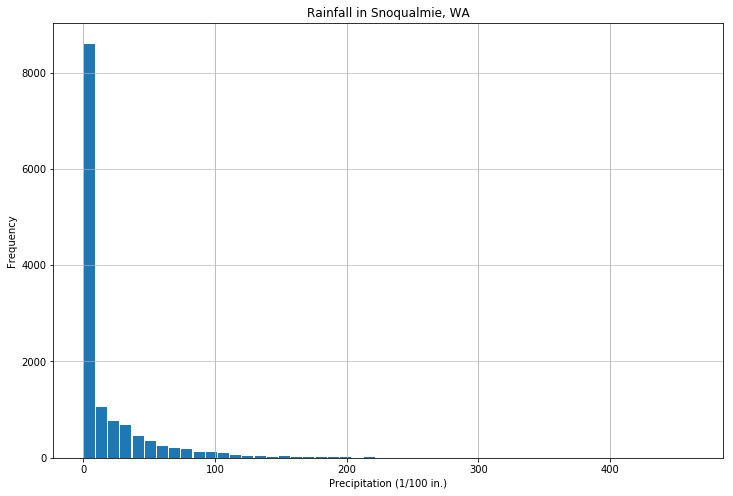

In [5]:
plt.close('all')
snoq['rainfall today'].plot.hist(bins=50, rwidth=0.9, grid=True, figsize=(12,8));
plt.title('Rainfall in Snoqualmie, WA')
plt.xlabel('Precipitation (1/100 in.)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

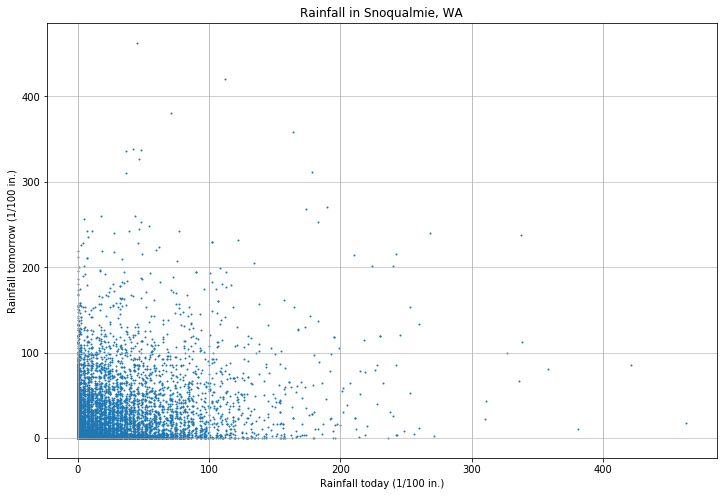

In [6]:
plt.close('all')
snoq.plot.scatter(x='rainfall today', y='rainfall tomorrow', s=1, grid=True, figsize=(12,8));
plt.title('Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Rainfall tomorrow (1/100 in.)')
plt.grid(axis='y', alpha=0.75)

In [41]:
# the data to use in the fit
X = snoq['rainfall today'].values
Y = snoq['rained tomorrow?'].values.astype(int)

In [48]:
from iminuit import Minuit
# MINUIT is a suite for numerical minimization and error estimation, originally written in FORTRAN
# define the loss function to minimize. We are using a linear logistic model
def neg2_log_likelihood(X,Y):
    assert(X.size == Y.size),"x size is {}, y size is {}. must be the same".format(x.size,y.size)
    assert(len(X.shape) == 1),"right now only 1 feature for x is allowed."
    def f(b,m):
        logl = 0
        for (xi,yi) in zip(X,Y):
            logl += -1.0*np.log(1+np.exp(b+(m*xi))) + yi*(b+(m*xi))
        return -2.0*logl
    return f

#The variance of the model b + mx will be sb^2 + x^2*sm^2 + 2Cov[sb,sm] assuming Gaussian noise
#regression curve with confidence interval of choice
def logit(b,m,sb2,sm2,cov_bm):
    def f(x, cl):
        mean = b+x*m
        std_err = cl*np.sqrt(sb2+(x*x*sm2)+(2*x*cov_bm))
        y = 1./(1.+np.exp(-(mean+std_err)))
        return y
    return f

def line(b,m,sb2,sm2,cov_bm):
    def f(x, cl):
        mean = b+x*m
        std_err = cl*np.sqrt(sb2+(x*x*sm2)+(2*x*cov_bm))
        y = mean+std_err
        return y
    return f

In [43]:
# minimize the negative log likelihood with migrad method (gradient descent)
snoq_likelihood = neg2_log_likelihood(X,Y)
nuit = Minuit(snoq_likelihood, m=0.5, b=0.1, error_m=0.1, error_b=0.1, errordef = 0.5)
nuit.migrad();
intercept = nuit.values["b"]
slope = nuit.values["m"]
print('intercept: {}, slope: {}'.format(intercept,slope))

FCN = 15889.305471585403 
 TOTAL NCALL = 66 
 NCALLS = 66 
 
 
 EDM = 1.9823891034332635e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 b 
 -0.43635 
 0.0152939 
 
 
 
 
 No 
 
 
 1 
 m 
 0.0453877 
 0.000926618 
 
 
 
 
 No

intercept: -0.4363497131636058, slope: 0.04538765658043042


In [44]:
#use the hessian for getting the correlation matrix of the errors. 
#This gives symmetric errors and assumes a multivariate gaussian distribution for the estimators
from pprint import pprint
nuit.hesse()
cov_matrix = nuit.np_matrix()
pprint(cov_matrix) 
print('std_dev b: {} \n std_dev m: {}'.format(np.sqrt(cov_matrix[0][0]),np.sqrt(cov_matrix[1][1])))

Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 b 
 -0.43635 
 0.0152932 
 
 
 
 
 No 
 
 
 1 
 m 
 0.0453877 
 0.000926578 
 
 
 
 
 No

b m 
 
 
 b 1.00 -0.48 
 
 
 m -0.48 1.00

array([[ 2.33882920e-04, -6.83997007e-06],
       [-6.83997007e-06,  8.58547213e-07]])
std_dev b: 0.015293231189521835 
 std_dev m: 0.0009265782280848452


In [45]:
from numpy.linalg import inv
#What about the std error?

def std_err(X,Y,b,m):
    assert(X.size == Y.size),"x size is {}, y size is {}. must be the same".format(x.size,y.size)
    assert(len(X.shape) == 1),"right now only 1 feature for x is allowed."
    likelihood = neg2_log_likelihood(X,Y)
    X_mat = X.reshape(-1,1)
    X_mat = np.concatenate((np.ones((len(Y),1)),X_mat),axis=1)
    errors = inv(np.dot(np.transpose(X_mat),X_mat))
    std_err = (likelihood(b,m)*errors)/float(len(Y)) # have to normalized the Y samples
    return std_err

cov_matrix = std_err(X,Y,intercept,slope)
pprint(cov_matrix)
print('std_dev b: {} \n std_dev m: {}'.format(np.sqrt(cov_matrix[0][0]),np.sqrt(cov_matrix[1][1])))

array([[ 1.16591836e-04, -1.45215464e-06],
       [-1.45215464e-06,  8.54541231e-08]])
std_dev b: 0.010797769973154427 
 std_dev m: 0.00029232537193990126


In [51]:
#prediction from logistic regression, as well as +/- 1sigma levels from the standard error
sample_best_fit_curve = logit(intercept, slope, cov_matrix[0][0],cov_matrix[1][1],cov_matrix[0][1])
sample_line = line(intercept, slope, cov_matrix[0][0],cov_matrix[1][1],cov_matrix[0][1])
xaxis = np.arange(0,500,1)
std_arr = np.array([0]*len(xaxis))
std_1err = np.array([1.96]*len(xaxis))
std_neg1err = np.array([-1.96]*len(xaxis))
sample_best_fit_curve = np.vectorize(sample_best_fit_curve)
sample_line = np.vectorize(sample_line)
yaxis = sample_best_fit_curve(xaxis,std_arr)
yaxis_1err = sample_best_fit_curve(xaxis,std_1err)
yaxis_neg1err = sample_best_fit_curve(xaxis,std_neg1err)
#yaxis = sample_line(xaxis,std_arr)
#yaxis_1err = sample_line(xaxis,std_1err)
#yaxis_neg1err = sample_line(xaxis,std_neg1err)

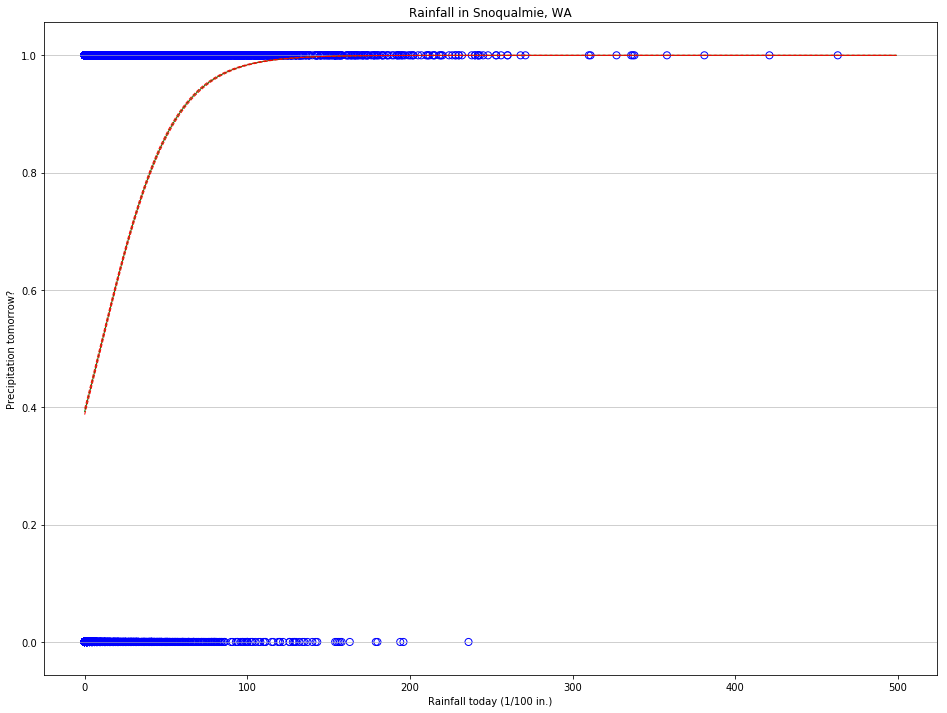

In [52]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.scatter(x=snoq['rainfall today'].values, y=snoq['rained tomorrow?'].values, s=50, color='blue',marker='o',facecolors='none');
plt.plot(xaxis,yaxis, linewidth=1,color='green') #regression line
plt.plot(xaxis,yaxis_1err, linewidth=1,color='red',linestyle='dashed') # 95% confidence up
plt.plot(xaxis,yaxis_neg1err, linewidth=1,color='red',linestyle='dashed') # 95% confidence down
plt.title('Rainfall in Snoqualmie, WA')
plt.xlabel('Rainfall today (1/100 in.)')
plt.ylabel('Precipitation tomorrow?')
plt.grid(axis='y', alpha=0.75)